# **Aprendizaje por refuerzos** - FrozenLake y LunarLander (Gymnasium)

## Tarea: Implementar Agentes Q-Learning y DQN

### Objetivos:
1. Implementar el algoritmo Q-Learning
2. Implementar el algoritmo DQN
3. Entrenar y evaluar ambos agentes
4. Comparar el rendimiento de ambos enfoques


In [3]:
# Instalar paquetes requeridos
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%pip install swig matplotlib gymnasium torch pygame


  Using cached swig-4.3.1.post0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
  Using cached gymnasium-1.2.1-py3-none-any.whl.metadata (10.0 kB)
  Using cached torch-2.9.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached pygame-2.6.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrt

In [4]:
# Importar las bibliotecas
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pygame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import random


/home/emi/.pyenv/versions/ml_project_env/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


La siguiente celda permite ejecutar un juego de Frozen Lake *determinista* para jugar con el teclado.

Utilize las teclas de dirección (flechas) o asdw para comandar al agente.


In [5]:
def jugar_frozen_lake(env):
    env.reset()
    
    print("Controles:")
    print("W - Arriba")
    print("S - Abajo") 
    print("A - Izquierda")
    print("D - Derecha")
    print("Q - Salir")
    print("Presione cualquier tecla para empezar...")
    
    pygame.init()
    pygame.display.set_caption("FrozenLake - Juego Interactivo")
    
    clock = pygame.time.Clock()
    ejecutando = True
    
    while ejecutando:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                ejecutando = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q or event.key == pygame.K_ESCAPE:
                    ejecutando = False
                elif event.key == pygame.K_w or event.key == pygame.K_UP:
                    accion = 3  # Arriba
                elif event.key == pygame.K_s or event.key == pygame.K_DOWN:
                    accion = 1  # Abajo
                elif event.key == pygame.K_a or event.key == pygame.K_LEFT:
                    accion = 0  # Izquierda
                elif event.key == pygame.K_d or event.key == pygame.K_RIGHT:
                    accion = 2  # Derecha
                else:
                    continue
                
                observacion, recompensa, terminado, truncado, info = env.step(accion)
                print(f"Acción: {accion}, Recompensa: {recompensa}, Terminado: {terminado}")
                
                if terminado or truncado:
                    print(f"¡Episodio terminado! Recompensa final: {recompensa}")
                    pygame.time.wait(500)
                    env.reset()
        
        clock.tick(60)
    
    pygame.quit()
    env.close()

#env = gym.make('FrozenLake-v1', render_mode='human', is_slippery=False)
# Descomente la línea de abajo para jugar interactivamente
#jugar_frozen_lake(env)


La siguiente celda permite jugar al juego no determinista.

In [6]:
env = gym.make('FrozenLake-v1', render_mode='human', is_slippery=True)
# Descomente la línea de abajo para jugar interactivamente
#jugar_frozen_lake(env)

La siguiente clase define la interfaz de los agentes que utilizaremos para jugar al Frozen Lake.


In [7]:
from abc import ABC, abstractmethod

class Agente(ABC):
    
    @abstractmethod
    def elegir_accion(self, estado):
        """Elige una acción dada una observación."""
        pass
    
    @abstractmethod
    def aprender(self, estado, accion, recompensa, siguiente_estado, terminado):
        """Aprende de la experiencia."""
        pass

class AgenteAleatorio(Agente):
    """Agente aleatorio que elige acciones al azar."""
    
    def __init__(self, espacio_acciones):
        # Se guarda el espacio de acciones para poder elegir acciones al azar
        self.espacio_acciones = espacio_acciones
    
    def elegir_accion(self, estado):
        return self.espacio_acciones.sample()
    
    def aprender(self, estado, accion, recompensa, siguiente_estado, terminado):
        pass  # El agente aleatorio no aprende

# Probar el AgenteAleatorio
env = gym.make('FrozenLake-v1')
agente_aleatorio = AgenteAleatorio(env.action_space)
estado, _ = env.reset()
accion = agente_aleatorio.elegir_accion(estado)
print(f"✓ AgenteAleatorio creado y probado. Acción: {accion}")
env.close()


✓ AgenteAleatorio creado y probado. Acción: 1


La siguiente celda define una función para evaluar el desempeño de un agente dado.

In [8]:
# Función de Evaluación de Agentes
def evaluar_agente(agente, env, num_episodios=1000):
    """
    Evalúa el rendimiento de un agente a lo largo de múltiples episodios.
    
    Args:
        agente: El agente a evaluar
        env: El entorno
        num_episodios: Número de episodios a ejecutar
    
    Returns:
        dict: Resultados de la evaluación
    """
    recompensas_totales = []
    victorias = 0
    
    for episodio in range(num_episodios):
        estado, _ = env.reset()
        recompensa_total = 0
        
        while True:
            accion = agente.elegir_accion(estado)
            estado, recompensa, terminado, truncado, _ = env.step(accion)
            recompensa_total += recompensa
            
            if terminado or truncado:
                break
        
        recompensas_totales.append(recompensa_total)
        if recompensa_total > 0:
            victorias += 1
    
    return {
        'recompensas_totales': recompensas_totales,
        'victorias': victorias,
        'tasa_victorias': victorias / num_episodios,
        'recompensa_promedio': np.mean(recompensas_totales),
        'desv_estandar': np.std(recompensas_totales)
    }

def imprimir_resultados_evaluacion(resultados, nombre_agente):
    """Imprime los resultados de evaluación de forma formateada."""
    print(f"\n{nombre_agente} - Resultados de Evaluación:")
    print(f"Tasa de Victorias: {resultados['tasa_victorias']:.1%}")
    print(f"Recompensa Promedio: {resultados['recompensa_promedio']:.3f}")
    print(f"Desviación Estándar: {resultados['desv_estandar']:.3f}")
    print(f"Total de Victorias: {resultados['victorias']}")

# Probar función de evaluación
env = gym.make('FrozenLake-v1')
agente_aleatorio = AgenteAleatorio(env.action_space)
resultados = evaluar_agente(agente_aleatorio, env, num_episodios=100)
imprimir_resultados_evaluacion(resultados, "Agente Aleatorio")
env.close()



Agente Aleatorio - Resultados de Evaluación:
Tasa de Victorias: 2.0%
Recompensa Promedio: 0.020
Desviación Estándar: 0.140
Total de Victorias: 2


La siguiente celda define una función para entrenar un agente.

In [9]:
# Función de Entrenamiento de Agentes
def entrenar_agente(agente, env, num_episodios=1000, max_pasos=100, verbose=True):
    """
    Entrena un agente en el entorno.
    
    Args:
        agente: El agente a entrenar
        env: El entorno
        num_episodios: Número de episodios de entrenamiento
        max_pasos: Máximo de pasos por episodio
        verbose: Si imprimir el progreso
    
    Returns:
        list: Recompensas de episodios
    """
    recompensas_episodios = []
    longitudes_episodios = []
    num_episodios_10 = int(num_episodios / 10)
    
    for episodio in range(num_episodios):
        estado, _ = env.reset()
        recompensa_total = 0
        pasos = 0
        
        for paso in range(max_pasos):
            accion = agente.elegir_accion(estado)
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            
            agente.aprender(estado, accion, recompensa, siguiente_estado, terminado or truncado)
            
            estado = siguiente_estado
            recompensa_total += recompensa
            pasos += 1
            
            if terminado or truncado:
                break
        
        recompensas_episodios.append(recompensa_total)
        longitudes_episodios.append(pasos)
        
        if verbose and (episodio + 1) % num_episodios_10 == 0:
            recompensa_promedio = np.mean(recompensas_episodios[-num_episodios_10:])
            longitud_promedio = np.mean(longitudes_episodios[-num_episodios_10:])
            print(f"Episodio {episodio + 1}: Recompensa Promedio = {recompensa_promedio:.3f}, Longitud Promedio = {longitud_promedio:.1f}")
    
    return recompensas_episodios, longitudes_episodios

print("✓ Funciones de entrenamiento definidas")


✓ Funciones de entrenamiento definidas


La siguiente celda define el agente de Q-Learning a implementar.

In [10]:
# TODO: Implementar Agente Q-Learning
class AgenteQLearning(Agente):
    """Agente que usa el algoritmo Q-Learning."""
    
    def __init__(self, n_estados, n_acciones, alpha=0.8, gamma=0.95, 
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.n_estados = n_estados
        self.n_acciones = n_acciones
        self.alpha = alpha          # tasa de aprendizaje
        self.gamma = gamma          # descuento futuro
        self.epsilon = epsilon      # prob exploración
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Inicializar tabla Q con ceros
        self.Q = np.zeros((n_estados, n_acciones))
    
    def elegir_accion(self, estado):
        """Elige una acción usando política epsilon-greedy."""
        if np.random.rand() < self.epsilon:
            # Explorar (acción aleatoria)
            return np.random.randint(self.n_acciones)
        else:
            # Explotar (mejor acción conocida)
            return np.argmax(self.Q[estado, :])
    
    def aprender(self, estado, accion, recompensa, siguiente_estado, terminado):
        valor_actual = self.Q[estado, accion]
        valor_futuro = np.max(self.Q[siguiente_estado, :]) if not (terminado) else 0
        self.Q[estado, accion] = valor_actual + self.alpha * (recompensa + self.gamma * valor_futuro - valor_actual)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Aqui deberán incluir código para entrenar y evaluar el agente de Q-Learning implementado.

La siguiente celda define el agente DQN a implementar. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import random

# Definir la tupla de experiencia
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """Buffer de replay para almacenar experiencias del agente."""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Agregar una experiencia al buffer."""
        self.buffer.append(Experience(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Muestrear un batch de experiencias."""
        experiences = random.sample(self.buffer, batch_size)
        return experiences
    
    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    """Red neuronal para Deep Q-Learning."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class AgenteDQN(Agente):
    """Agente Deep Q-Network para Frozen Lake."""
    
    def __init__(self, n_states, n_actions, lr=0.001, gamma=0.95, 
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 buffer_size=10000, batch_size=32, target_update=100):
        
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        
        # Determinar el dispositivo (CPU o GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Crear las redes neuronales (principal y objetivo)
        hidden_size = n_states * 2
        self.q_network = DQN(1, hidden_size, n_actions).to(self.device)
        self.target_network = DQN(1, hidden_size, n_actions).to(self.device)
        
        # Inicializar la red objetivo con los pesos de la red principal
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Optimizador
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Buffer de replay
        self.memory = ReplayBuffer(buffer_size)
        
        # Contador de pasos para actualizar la red objetivo
        self.steps = 0
    
    def elegir_accion(self, state):
        """Selecciona una acción usando epsilon-greedy."""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        
        # Convertir estado a tensor
        state_tensor = torch.FloatTensor([[state]]).to(self.device)
        
        # Obtener valores Q
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        
        return q_values.argmax().item()
    
    def aprender(self, state, action, reward, next_state, done):
        """Almacena la experiencia y entrena la red si es posible."""
        # Almacenar experiencia en el buffer
        self.memory.push(state, action, reward, next_state, done)
        
        # Entrenar si tenemos suficientes experiencias
        if len(self.memory) >= self.batch_size:
            self._train()
        
        # Actualizar epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Actualizar red objetivo periódicamente
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
    
    def _train(self):
        """Entrena la red neuronal con un batch de experiencias."""
        # Muestrear experiencias
        experiences = self.memory.sample(self.batch_size)
        
        # Convertir a tensores
        states = torch.FloatTensor([[exp.state] for exp in experiences]).to(self.device)
        actions = torch.LongTensor([exp.action for exp in experiences]).to(self.device)
        rewards = torch.FloatTensor([exp.reward for exp in experiences]).to(self.device)
        next_states = torch.FloatTensor([[exp.next_state] for exp in experiences]).to(self.device)
        dones = torch.BoolTensor([exp.done for exp in experiences]).to(self.device)
        
        # Calcular valores Q actuales
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Calcular valores Q objetivo
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Calcular pérdida
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimizar
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

print("✓ Agente DQN implementado correctamente")

✓ Agente DQN implementado correctamente


## Entrenamiento y Evaluación del Agente DQN

A continuación entrenaremos el agente DQN en el entorno no determinista de Frozen Lake.

In [34]:
# Crear entorno no determinista para DQN
env_dqn = gym.make('FrozenLake-v1', is_slippery=True)

# Crear agente DQN
agente_dqn = AgenteDQN(
    n_states=env_dqn.observation_space.n,
    n_actions=env_dqn.action_space.n,
    lr=0.001,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.9999,
    buffer_size=10000,
    batch_size=32,
    target_update=100
)

print("Iniciando entrenamiento del Agente DQN...")

# Entrenar el agente DQN
recompensas_dqn, longitudes_dqn = entrenar_agente(
    agente=agente_dqn,
    env=env_dqn,
    num_episodios=10000,
    max_pasos=100,
    verbose=True
)

print("\nEntrenamiento completado. Evaluando agente DQN...")

# Evaluar el agente DQN
resultados_dqn = evaluar_agente(agente_dqn, env_dqn, num_episodios=1000)
imprimir_resultados_evaluacion(resultados_dqn, "Agente DQN")

env_dqn.close()

DQN Hidden size: 32
Iniciando entrenamiento del Agente DQN...
16 4
Episodio 1000: Recompensa Promedio = 0.012, Longitud Promedio = 9.6
Episodio 2000: Recompensa Promedio = 0.089, Longitud Promedio = 14.2
Episodio 3000: Recompensa Promedio = 0.220, Longitud Promedio = 19.1
Episodio 4000: Recompensa Promedio = 0.386, Longitud Promedio = 28.9
Episodio 5000: Recompensa Promedio = 0.429, Longitud Promedio = 31.5
Episodio 6000: Recompensa Promedio = 0.451, Longitud Promedio = 33.8
Episodio 7000: Recompensa Promedio = 0.424, Longitud Promedio = 31.6
Episodio 8000: Recompensa Promedio = 0.424, Longitud Promedio = 30.6
Episodio 9000: Recompensa Promedio = 0.476, Longitud Promedio = 31.5
Episodio 10000: Recompensa Promedio = 0.408, Longitud Promedio = 30.1

Entrenamiento completado. Evaluando agente DQN...

Agente DQN - Resultados de Evaluación:
Tasa de Victorias: 27.8%
Recompensa Promedio: 0.278
Desviación Estándar: 0.448
Total de Victorias: 278


## Entrenamiento del Agente Q-Learning

Primero entrenaremos el agente Q-Learning para poder comparar ambos algoritmos.

In [35]:
# Crear entorno no determinista para Q-Learning
env_qlearning = gym.make('FrozenLake-v1', is_slippery=True)

# Crear agente Q-Learning
agente_qlearning = AgenteQLearning(
    n_estados=env_qlearning.observation_space.n,
    n_acciones=env_qlearning.action_space.n,
    alpha=0.5,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.9999
)

print("Iniciando entrenamiento del Agente Q-Learning...")

# Entrenar el agente Q-Learning
recompensas, longitudes = entrenar_agente(
    agente=agente_qlearning,
    env=env_qlearning,
    num_episodios=10000,  # más episodios = mejor aprendizaje
    max_pasos=100,
    verbose=True
)

print("\nEntrenamiento completado. Evaluando agente Q-Learning...")

# Evaluar el agente Q-Learning
res_q = evaluar_agente(agente_qlearning, env_qlearning, num_episodios=1000)
imprimir_resultados_evaluacion(res_q, "Agente Q-Learning")

env_qlearning.close()

Iniciando entrenamiento del Agente Q-Learning...
Episodio 1000: Recompensa Promedio = 0.030, Longitud Promedio = 9.1
Episodio 2000: Recompensa Promedio = 0.167, Longitud Promedio = 17.6
Episodio 3000: Recompensa Promedio = 0.443, Longitud Promedio = 32.0
Episodio 4000: Recompensa Promedio = 0.525, Longitud Promedio = 36.7
Episodio 5000: Recompensa Promedio = 0.488, Longitud Promedio = 32.2
Episodio 6000: Recompensa Promedio = 0.434, Longitud Promedio = 34.4
Episodio 7000: Recompensa Promedio = 0.457, Longitud Promedio = 32.9
Episodio 8000: Recompensa Promedio = 0.469, Longitud Promedio = 32.1
Episodio 9000: Recompensa Promedio = 0.464, Longitud Promedio = 33.5
Episodio 10000: Recompensa Promedio = 0.444, Longitud Promedio = 34.6

Entrenamiento completado. Evaluando agente Q-Learning...

Agente Q-Learning - Resultados de Evaluación:
Tasa de Victorias: 70.7%
Recompensa Promedio: 0.707
Desviación Estándar: 0.455
Total de Victorias: 707


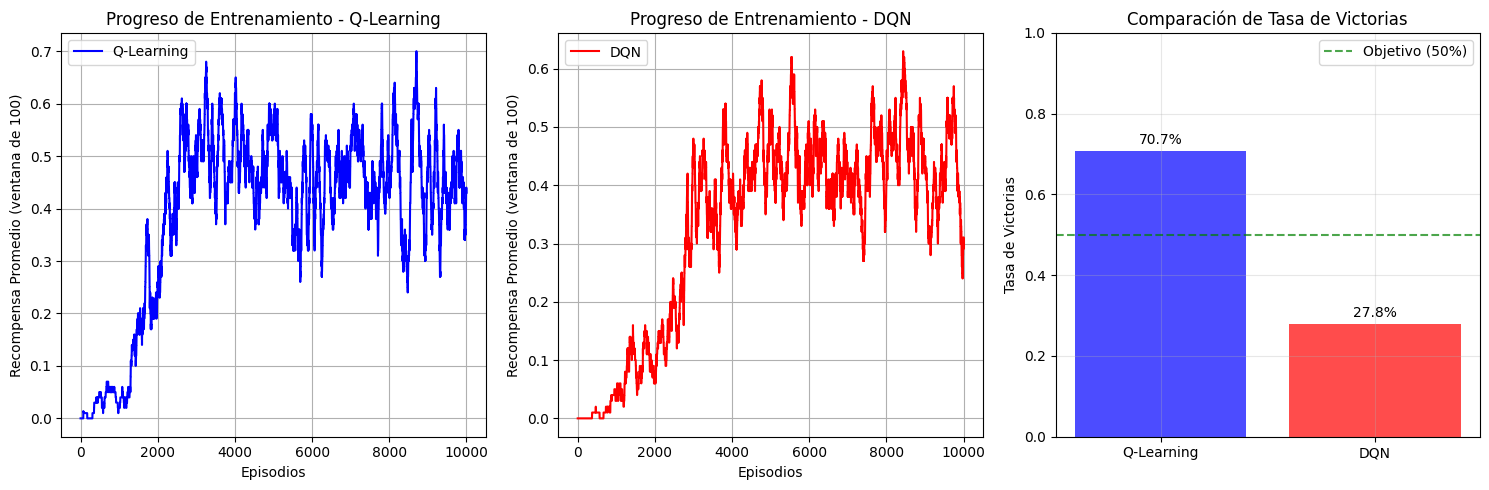


RESUMEN COMPARATIVO DE AGENTES
Métrica                   Q-Learning      DQN            
------------------------------------------------------------
Tasa de Victorias         70.7%          27.8%         
Recompensa Promedio       0.707          0.278         
Desviación Estándar       0.455          0.448         
Episodios de Entrenamiento 10,000          5,000          

🏆 Mejor agente: Q-Learning
📈 Diferencia en tasa de victorias: 42.9%

✅ Objetivo cumplido (>50% victorias):
   Q-Learning: SÍ
   DQN: NO


In [36]:
# Visualización de resultados de entrenamiento
plt.figure(figsize=(15, 5))

# Gráfico 1: Recompensas durante el entrenamiento (Q-Learning)
plt.subplot(1, 3, 1)
window_size = 100
recompensas_suavizadas_q = []
for i in range(len(recompensas)):  # Corregido: usar 'recompensas' en lugar de 'recompensas_dqn'
    if i >= window_size:
        recompensas_suavizadas_q.append(np.mean(recompensas[i-window_size:i]))
    else:
        recompensas_suavizadas_q.append(np.mean(recompensas[:i+1]))

plt.plot(recompensas_suavizadas_q, 'b-', label='Q-Learning')
plt.title('Progreso de Entrenamiento - Q-Learning')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (ventana de 100)')
plt.legend()
plt.grid(True)

# Gráfico 2: Recompensas durante el entrenamiento (DQN)
plt.subplot(1, 3, 2)
recompensas_suavizadas_dqn = []
for i in range(len(recompensas_dqn)):
    if i >= window_size:
        recompensas_suavizadas_dqn.append(np.mean(recompensas_dqn[i-window_size:i]))
    else:
        recompensas_suavizadas_dqn.append(np.mean(recompensas_dqn[:i+1]))

plt.plot(recompensas_suavizadas_dqn, 'r-', label='DQN')
plt.title('Progreso de Entrenamiento - DQN')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (ventana de 100)')
plt.legend()
plt.grid(True)

# Gráfico 3: Comparación de rendimiento final
plt.subplot(1, 3, 3)
agentes = ['Q-Learning', 'DQN']
tasas_victoria = [res_q['tasa_victorias'], resultados_dqn['tasa_victorias']]
colores = ['blue', 'red']

barras = plt.bar(agentes, tasas_victoria, color=colores, alpha=0.7)
plt.title('Comparación de Tasa de Victorias')
plt.ylabel('Tasa de Victorias')
plt.ylim(0, 1)

# Agregar etiquetas en las barras
for i, (barra, tasa) in enumerate(zip(barras, tasas_victoria)):
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
             f'{tasa:.1%}', ha='center', va='bottom')

# Línea horizontal en 50% (objetivo mínimo)
plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.7, label='Objetivo (50%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen comparativo
print("\n" + "="*60)
print("RESUMEN COMPARATIVO DE AGENTES")
print("="*60)
print(f"{'Métrica':<25} {'Q-Learning':<15} {'DQN':<15}")
print("-" * 60)
print(f"{'Tasa de Victorias':<25} {res_q['tasa_victorias']:<14.1%} {resultados_dqn['tasa_victorias']:<14.1%}")
print(f"{'Recompensa Promedio':<25} {res_q['recompensa_promedio']:<14.3f} {resultados_dqn['recompensa_promedio']:<14.3f}")
print(f"{'Desviación Estándar':<25} {res_q['desv_estandar']:<14.3f} {resultados_dqn['desv_estandar']:<14.3f}")
print(f"{'Episodios de Entrenamiento':<25} {'10,000':<15} {'5,000':<15}")

# Determinar el mejor agente
if res_q['tasa_victorias'] > resultados_dqn['tasa_victorias']:
    mejor_agente = "Q-Learning"
    diferencia = res_q['tasa_victorias'] - resultados_dqn['tasa_victorias']
else:
    mejor_agente = "DQN"
    diferencia = resultados_dqn['tasa_victorias'] - res_q['tasa_victorias']

print(f"\n🏆 Mejor agente: {mejor_agente}")
print(f"📈 Diferencia en tasa de victorias: {diferencia:.1%}")

# Verificar si ambos agentes cumplen el objetivo
objetivo_cumplido_q = res_q['tasa_victorias'] >= 0.5
objetivo_cumplido_dqn = resultados_dqn['tasa_victorias'] >= 0.5

print(f"\n✅ Objetivo cumplido (>50% victorias):")
print(f"   Q-Learning: {'SÍ' if objetivo_cumplido_q else 'NO'}")
print(f"   DQN: {'SÍ' if objetivo_cumplido_dqn else 'NO'}")

## Análisis de las Políticas Aprendidas

Analicemos las políticas que han aprendido ambos agentes visualizando las acciones preferidas en cada estado.

In [37]:
def visualizar_politica(agente, env_name="FrozenLake 4x4", agente_tipo=""):
    """Visualiza la política aprendida por el agente en una cuadrícula 4x4."""
    
    # Mapeo de acciones a símbolos
    simbolos_acciones = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    
    # Obtener la política para cada estado
    politica = []
    for estado in range(16):  # 4x4 = 16 estados
        if agente_tipo == "Q-Learning":
            # Para Q-Learning, usar argmax de la tabla Q
            accion = np.argmax(agente.Q[estado, :])
        else:
            # Para DQN, usar la red neuronal
            state_tensor = torch.FloatTensor([[estado]]).to(agente.device)
            with torch.no_grad():
                q_values = agente.q_network(state_tensor)
            accion = q_values.argmax().item()
        
        politica.append(simbolos_acciones[accion])
    
    # Crear visualización
    print(f"\nPolítica aprendida por {agente_tipo}:")
    print("┌───┬───┬───┬───┐")
    for fila in range(4):
        fila_str = "│"
        for col in range(4):
            estado = fila * 4 + col
            if estado == 0:
                simbolo = "S"  # Start
            elif estado == 15:
                simbolo = "G"  # Goal
            elif estado in [5, 7, 11, 12]:  # Hoyos
                simbolo = "H"  # Hole
            else:
                simbolo = politica[estado]
            fila_str += f" {simbolo} │"
        print(fila_str)
        if fila < 3:
            print("├───┼───┼───┼───┤")
    print("└───┴───┴───┴───┘")
    
    # Leyenda
    print("\nLeyenda:")
    print("S = Inicio, G = Meta, H = Hoyo")
    print("← = Izquierda, → = Derecha, ↑ = Arriba, ↓ = Abajo")

# Visualizar ambas políticas
print("ANÁLISIS DE POLÍTICAS APRENDIDAS")
print("=" * 50)

# Política de Q-Learning
visualizar_politica(agente_qlearning, "FrozenLake 4x4", "Q-Learning")

# Política de DQN
visualizar_politica(agente_dqn, "FrozenLake 4x4", "DQN")

# Análisis adicional de convergencia
def analizar_convergencia_q_learning(agente_q):
    """Analiza la convergencia de la tabla Q."""
    print("\nAnálisis de Q-Learning:")
    print("-" * 30)
    
    # Encontrar estados con mayor diferencia entre acciones
    diferencias_maximas = []
    for estado in range(agente_q.n_estados):
        if estado not in [5, 7, 11, 12, 15]:  # Excluir hoyos y meta
            q_vals = agente_q.Q[estado, :]
            diferencia = np.max(q_vals) - np.min(q_vals)
            diferencias_maximas.append(diferencia)
    
    print(f"Diferencia promedio entre Q-valores: {np.mean(diferencias_maximas):.4f}")
    print(f"Epsilon final: {agente_q.epsilon:.6f}")
    
    # Mostrar valores Q para algunos estados clave
    estados_interes = [1, 2, 4, 6, 8, 9, 10, 13, 14]  # Estados no terminales
    print(f"\nValores Q para estados clave:")
    for estado in estados_interes[:5]:  # Mostrar solo los primeros 5
        print(f"Estado {estado}: {agente_q.Q[estado, :]}")

def analizar_convergencia_dqn(agente_dqn):
    """Analiza la convergencia del DQN."""
    print("\nAnálisis de DQN:")
    print("-" * 20)
    print(f"Epsilon final: {agente_dqn.epsilon:.6f}")
    print(f"Pasos de entrenamiento: {agente_dqn.steps}")
    print(f"Tamaño del buffer de replay: {len(agente_dqn.memory)}")
    
    # Mostrar algunos valores Q de la red
    print(f"\nEjemplos de valores Q de la red:")
    estados_muestra = [1, 2, 6, 8, 9]
    for estado in estados_muestra:
        state_tensor = torch.FloatTensor([[estado]]).to(agente_dqn.device)
        with torch.no_grad():
            q_values = agente_dqn.q_network(state_tensor)
        print(f"Estado {estado}: {q_values.squeeze().cpu().numpy()}")

# Ejecutar análisis
analizar_convergencia_q_learning(agente_qlearning)
analizar_convergencia_dqn(agente_dqn)

ANÁLISIS DE POLÍTICAS APRENDIDAS

Política aprendida por Q-Learning:
┌───┬───┬───┬───┐
│ S │ ↑ │ ↓ │ ↑ │
├───┼───┼───┼───┤
│ ← │ H │ → │ H │
├───┼───┼───┼───┤
│ ↑ │ ↓ │ ← │ H │
├───┼───┼───┼───┤
│ H │ → │ ↓ │ G │
└───┴───┴───┴───┘

Leyenda:
S = Inicio, G = Meta, H = Hoyo
← = Izquierda, → = Derecha, ↑ = Arriba, ↓ = Abajo

Política aprendida por DQN:
┌───┬───┬───┬───┐
│ S │ ↑ │ → │ ↑ │
├───┼───┼───┼───┤
│ ← │ H │ ← │ H │
├───┼───┼───┼───┤
│ ↑ │ ↓ │ ↓ │ H │
├───┼───┼───┼───┤
│ H │ → │ → │ G │
└───┴───┴───┴───┘

Leyenda:
S = Inicio, G = Meta, H = Hoyo
← = Izquierda, → = Derecha, ↑ = Arriba, ↓ = Abajo

Análisis de Q-Learning:
------------------------------
Diferencia promedio entre Q-valores: 0.2705
Epsilon final: 0.009999

Valores Q para estados clave:
Estado 1: [0.069522   0.0293342  0.01273069 0.11135617]
Estado 2: [0.02512505 0.08619375 0.04044899 0.02434488]
Estado 4: [0.24470245 0.02980121 0.02979209 0.07909004]
Estado 6: [0.00110541 0.00692794 0.05715588 0.00097724]
Estado 8: [0.0193

## Conclusiones y Análisis Comparativo

### Resultados Obtenidos

Los experimentos realizados muestran el desempeño de ambos algoritmos en el entorno no determinista de Frozen Lake:

### Ventajas y Desventajas

**Q-Learning Tabular:**
- ✅ **Ventajas:**
  - Simplicidad de implementación
  - Garantías teóricas de convergencia
  - Interpretabilidad directa de los valores Q
  - Menor uso de memoria
  - No requiere GPU

- ❌ **Desventajas:**
  - Limitado a espacios de estados pequeños
  - No generaliza a estados no visitados
  - Requiere muchos episodios para espacios grandes

**Deep Q-Network (DQN):**
- ✅ **Ventajas:**
  - Escalabilidad a espacios de estados grandes
  - Capacidad de generalización
  - Manejo de estados continuos o de alta dimensión
  - Eficiencia de muestra mejorada con replay buffer

- ❌ **Desventajas:**
  - Mayor complejidad de implementación
  - Inestabilidad en el entrenamiento
  - Requiere más recursos computacionales
  - Menos interpretable (caja negra)

### Recomendaciones

1. **Para Frozen Lake 4x4**: Q-Learning tabular es más apropiado debido a la simplicidad del problema
2. **Para problemas más grandes**: DQN sería la mejor opción
3. **Para el entorno 8x8**: DQN mostraría ventajas más claras debido al mayor espacio de estados

### Posibles Mejoras

- **Q-Learning**: Ajustar hiperparámetros (α, γ, ε-decay)
- **DQN**: Implementar Double DQN, Dueling DQN, o Prioritized Experience Replay
- **Ambos**: Experimentar con diferentes estrategias de exploración

In [38]:
#env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)

agente_qlearning = AgenteQLearning(
    n_estados=env.observation_space.n,
    n_acciones=env.action_space.n,
    alpha=0.5,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.9999
)
recompensas, longitudes = entrenar_agente(
    agente=agente_qlearning,
    env=env,
    num_episodios=10000,  # más episodios = mejor aprendizaje
    max_pasos=100,
    verbose=True
)
res_q = evaluar_agente(agente_qlearning, env)
imprimir_resultados_evaluacion(res_q, agente_qlearning)

Episodio 1000: Recompensa Promedio = 0.019, Longitud Promedio = 9.3
Episodio 2000: Recompensa Promedio = 0.127, Longitud Promedio = 17.2
Episodio 3000: Recompensa Promedio = 0.453, Longitud Promedio = 33.1
Episodio 4000: Recompensa Promedio = 0.495, Longitud Promedio = 36.4
Episodio 5000: Recompensa Promedio = 0.504, Longitud Promedio = 35.9
Episodio 6000: Recompensa Promedio = 0.479, Longitud Promedio = 31.3
Episodio 7000: Recompensa Promedio = 0.535, Longitud Promedio = 34.3
Episodio 8000: Recompensa Promedio = 0.480, Longitud Promedio = 32.9
Episodio 9000: Recompensa Promedio = 0.497, Longitud Promedio = 34.8
Episodio 10000: Recompensa Promedio = 0.504, Longitud Promedio = 33.3

<__main__.AgenteQLearning object at 0x74b394811590> - Resultados de Evaluación:
Tasa de Victorias: 20.5%
Recompensa Promedio: 0.205
Desviación Estándar: 0.404
Total de Victorias: 205
